## Background
Natural language processing (NLP) began in the 1950s as the intersection between artificial intelligence and linguistics became prominent. There are various applications of NLP, with familiar applications such as sentiment analysis and text classification. For the purpose of this paper we will be exploring the application of NLP to build a content-based recommendation system. The goal of content-based filtering is to make an item-based recommendation to a user based on attributes of the item. For our example we will define an item as a textbook used in an Australian school and the attribute being features such as (1) description, (2) author and (3) publisher when available; with our user being defined as someone who needs a textbook for a particular subject (i.e. Year 12 English). All analysis was conducted using Jupyter Notebook with Python version 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)].

In [1]:
# Import required packages
import sys
import random
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import tqdm
import time
import datetime
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Define stop words
stop_words = set(stopwords.words('english'))
stop_words.add('etc/')

# Define file paths
file_path = 'C:/Users/jayde/OneDrive - James Cook University/Desktop/MA5851/Assignment 1/'
file_name = 'MA5851_SP82_2023_A1_Data.xlsx'

# Functions for text cleaning and analysis

def clean_html(text):
    # Remove HTML tags
    soup = BeautifulSoup(text, 'html.parser')
    clean_text = soup.get_text()
    # Remove any remaining non-alphabetic characters and convert to lowercase
    clean_text = re.sub('[^a-zA-Z]', ' ', clean_text).lower()
    # Remove any extra whitespace
    clean_text = ' '.join(clean_text.split())
    return clean_text

def clean_text(text):
    # Remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # Remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # Remove whitespaces 
    text = ' '.join(text.split()) 
    # Convert text to lowercase 
    text = text.lower() 
    return text

def remove_stopwords_and_stem(text):
    # Remove stop words and stem words
    stemmer = PorterStemmer()
    tokens = word_tokenize(text.lower())
    no_stopword_text = [stemmer.stem(w) for w in tokens if not w in stop_words]
    return ' '.join(no_stopword_text)

def freq_words(x, terms = 30): 
    # Get frequency distribution of words in text
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
    # Select top n most frequent words and plot them
    d = words_df.nlargest(columns="count", n=terms) 
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x="count", y="word") 
    ax.set(ylabel='Word') 
    plt.show()
print(sys.version)

3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jayde\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jayde\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data overview:
Data was obtained from the MA5851 Assessment 1 folder on learn JCU and downloaded on 19th March 2023. The data was saved locally and imported into python for data pre-processing and analysis. The provided data includes information about the ISBN numbers of textbooks used in Australian schools, as well as additional variables such as the unique identifier for the school, the state in which the school resides in, the year level for which the text book is used for, and the subject area for which the book is assumed to be used in; noting that subject area information may be inaccurate. 
Table 1 summarised the data dimensions and data types for each column. The initial data set contained 5 columns and 1804 rows. 


In [2]:
# Load in isbn data sheet
isbn_data = pd.read_excel(f"{file_path}{file_name}", sheet_name='ISBN_Data')
user_data = isbn_data
isbn_data.head()  # Cofirm loaded  correctly


,School_ID,State,Year,Subject,ISBN
0,8,VIC,0,ENGLISH,9781741250879
1,9,NSW,0,ENGLISH,9780648237327
2,15,NSW,0,ENGLISH,9781742990682
3,15,NSW,0,ENGLISH,9781741351750
4,15,NSW,0,ENGLISH,9781742152196


In [3]:
num_rows = isbn_data.shape[0]
num_cols = isbn_data.shape[1]

print('Number of rows:', num_rows)
print('Number of columns:', num_cols)

# print column names and data types
print(isbn_data.dtypes)

Number of rows: 1804
Number of columns: 5
School_ID     int64
State        object
Year          int64
Subject      object
ISBN          int64
dtype: object


# Sample Data Pre-Processing / Sample Data Analysis (EDA)
- Step 1: Correct data type
- Step 2: Duplicate observations (multiple classes at a school possibly)
- Step 3: Review and correct subjects
- Step 4: Do we remove low observations based on our user? 


To optimize our NLP recommendation system, we performed four pre-processing steps on the sample data from the JCU folder. These steps ensured that the data was of the correct data type, free of duplications, and had any errors reviewed and corrected. We converted School_ID, State, Year, and Subject to categorical data types and removed 127 duplicates from the dataset. Although we hypothesized that this could be due to a school having multiple classes for a particular subject. We also reviewed the distribution of subjects and noticed that English was listed in three different ways. To standardize the data, we renamed ‘english’ and ‘ENGLISH LITERARY STUDIES’ as ‘ENGLISH’ and assumed that all other subjects appeared correctly. 
In data science, a common challenge is that data is often not initially in a usable format, which requires significant time to transform. We suggested a solution for our NLP classification recommendation model, which involved creating a data frame with a unique ISBN in each row and a second column listing known users of the corresponding textbook. This would enable us to recommend textbooks based on features such as author, description, title, and category and evaluate the model's performance using a ground truth method (Datagen, ND). We can use the known users of each textbook to compare the model's recommended textbooks and assess its accuracy and effectiveness (Datagen, ND).


In [4]:
# STEP 1
# Convert data type to categorical as required
isbn_data['School_ID'] = isbn_data['School_ID'].astype('category')
isbn_data['State'] = isbn_data['State'].astype('category')
isbn_data['Year'] = isbn_data['Year'].astype('category')
isbn_data['Subject'] = isbn_data['Subject'].astype('category')

# Confrim above worked
print(isbn_data.dtypes)

School_ID    category
State        category
Year         category
Subject      category
ISBN            int64
dtype: object


In [5]:
# STEP 2
num_rows_before = isbn_data.shape[0]

isbn_data_2 = isbn_data.drop_duplicates(keep='first')

num_rows_after = isbn_data_2.shape[0]
num_rows_dropped = num_rows_before - num_rows_after

print('Number of rows dropped:', num_rows_dropped)

print(isbn_data_2)

Number of rows dropped: 127
     School_ID State Year     Subject           ISBN
0            8   VIC    0     ENGLISH  9781741250879
1            9   NSW    0     ENGLISH  9780648237327
2           15   NSW    0     ENGLISH  9781742990682
3           15   NSW    0     ENGLISH  9781741351750
4           15   NSW    0     ENGLISH  9781742152196
...        ...   ...  ...         ...            ...
1799         2   VIC   12  ACCOUNTING  9781108688772
1800         2   VIC   12  ACCOUNTING  9781108469913
1801        19   VIC   12  ACCOUNTING  9781108688772
1802         1   NSW   12   LANGUAGES  9781568364575
1803         6   VIC   12     SCIENCE  9781876703431

[1677 rows x 5 columns]


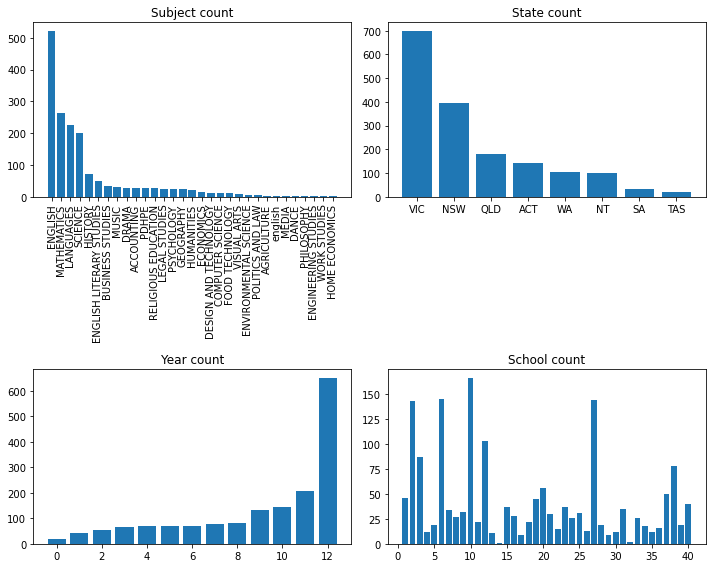

ENGLISH                     522
MATHEMATICS                 263
LANGUAGES                   226
SCIENCE                     199
HISTORY                      71
ENGLISH LITERARY STUDIES     48
BUSINESS STUDIES             35
MUSIC                        30
DRAMA                        28
ACCOUNTING                   26
PDHPE                        26
RELIGIOUS EDUCATION          26
LEGAL STUDIES                25
PSYCHOLOGY                   24
GEOGRAPHY                    23
HUMANITIES                   22
ECONOMICS                    15
DESIGN AND TECHNOLOGY        13
COMPUTER SCIENCE             13
FOOD TECHNOLOGY              11
VISUAL ARTS                   8
ENVIRONMENTAL SCIENCE         6
POLITICS AND LAW              4
AGRICULTURE                   3
english                       2
MEDIA                         2
DANCE                         2
PHILOSOPHY                    1
ENGINEERING STUDIES           1
WORK STUDIES                  1
HOME ECONOMICS                1
Name: Su

In [6]:
# EDA: Produce some visuals to get an undertsanding for the data
subject_count = isbn_data_2['Subject'].value_counts()
state_count = isbn_data_2['State'].value_counts()
year_count = isbn_data_2['Year'].value_counts()
school_count = isbn_data_2['School_ID'].value_counts()


# Create subplots for each count variable
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Subject count
axs[0, 0].bar(subject_count.index, subject_count.values)
axs[0, 0].set_title('Subject count')
axs[0, 0].tick_params(axis='x', rotation=90) # Add this line to rotate the labels


# State count
axs[0, 1].bar(state_count.index, state_count.values)
axs[0, 1].set_title('State count')

# Year count
axs[1, 0].bar(year_count.index, year_count.values)
axs[1, 0].set_title('Year count')

# School count
axs[1, 1].bar(school_count.index, school_count.values)
axs[1, 1].set_title('School count')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
print(subject_count)

In [7]:
# Step 3: Correct subjects
isbn_data_2['Subject'] = isbn_data_2['Subject'].str.strip()

# Replace 'english' and 'ENGLISH LITERARY STUDIES' with 'ENGLISH'
isbn_data_2.loc[isbn_data_2['Subject'].isin(['english', 'ENGLISH LITERARY STUDIES']), 'Subject'] = 'ENGLISH'

# Count the number of occurrences of each subject
subject_count = isbn_data_2['Subject'].value_counts()
print(subject_count)

# Identify subjects with fewer than 10 occurrences
#mask = isbn_data_2['Subject'].isin(subject_count.index[subject_count < 10])

# Filter the rows of the DataFrame using the mask
#isbn_data_2 = isbn_data_2[~mask]

# Print the updated value counts of the Subject column
#subject_count = isbn_data_2['Subject'].value_counts()
#print(subject_count)


ENGLISH                  572
MATHEMATICS              263
LANGUAGES                226
SCIENCE                  199
HISTORY                   71
BUSINESS STUDIES          35
MUSIC                     30
DRAMA                     28
PDHPE                     26
ACCOUNTING                26
RELIGIOUS EDUCATION       26
LEGAL STUDIES             25
PSYCHOLOGY                24
GEOGRAPHY                 23
HUMANITIES                22
ECONOMICS                 15
COMPUTER SCIENCE          13
DESIGN AND TECHNOLOGY     13
FOOD TECHNOLOGY           11
VISUAL ARTS                8
ENVIRONMENTAL SCIENCE      6
POLITICS AND LAW           4
AGRICULTURE                3
MEDIA                      2
DANCE                      2
ENGINEERING STUDIES        1
HOME ECONOMICS             1
WORK STUDIES               1
PHILOSOPHY                 1
Name: Subject, dtype: int64


C:\Users\jayde\AppData\Local\Temp/ipykernel_36584/81281456.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isbn_data_2['Subject'] = isbn_data_2['Subject'].str.strip()
C:\Users\jayde\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


# Who are our users of NLP recomendation?
- user_1: Could be based on year & subject
- user_2: Could be based on subject
- user_3: Could be based on year level

We consulted the literature to gain domain expertise on the Australian education system, which helped us create contextually informed models for more accurate predictions. For our recommendation system, we selected users based on subject and year level to recommend textbooks appropriate for their teaching level for our ground truth (Moam Grammer, 2015; Datagen, ND). To validate our approach, we counted the number of defined users per ISBN and found that some subject textbooks spanned multiple year levels. However, during desktop research, we discovered that five specific ISBNs also spanned vastly different subjects, such as dictionaries and blank notebooks (as shown in Figure 2 for illustrative purposes). Therefore, we removed them from our analysis to reduce noise & API calls in the next section, resulting in 1066 unique ISBNs. At this stage we retained all users.

C:\Users\jayde\AppData\Local\Temp/ipykernel_36584/520417935.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isbn_data_3['Year'] = isbn_data_3['Year'].astype(str)  # convert Year column to string data type
C:\Users\jayde\AppData\Local\Temp/ipykernel_36584/520417935.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isbn_data_3['Subject'] = isbn_data_3['Subject'].astype(str)  # convert Subject column to string data type


               ISBN                                          User_type
0     2019052211324                                         [MUSIC_12]
1     9780006755234                                        [ENGLISH_9]
2     9780007141425                                        [ENGLISH_7]
3     9780007456208                                        [ENGLISH_4]
4     9780007485505                         [LANGUAGES_8, LANGUAGES_9]
...             ...                                                ...
1066  9789814779098                               [COMPUTER SCIENCE_7]
1067  9789814792530                                     [LANGUAGES_11]
1068  9789814792547                                     [LANGUAGES_11]
1069  9789839494488                                     [LANGUAGES_12]
1070  9798708474995  [ENGLISH_11, MATHEMATICS_10, SCIENCE_8, HISTOR...

[1071 rows x 2 columns]


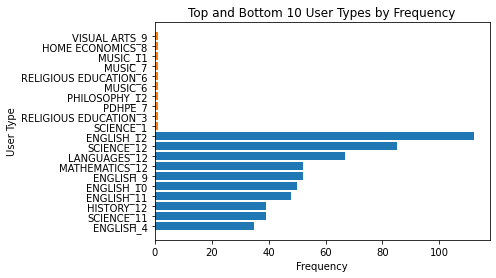

ENGLISH_12            112
SCIENCE_12             85
LANGUAGES_12           67
MATHEMATICS_12         52
ENGLISH_9              52
                     ... 
FOOD TECHNOLOGY_11      1
ACCOUNTING_2            1
HISTORY_5               1
PDHPE_10                1
SCIENCE_1               1
Name: User_type, Length: 146, dtype: int64


In [8]:

isbn_data_3 = isbn_data_2[['Year', 'Subject', 'ISBN']]
isbn_data_3['Year'] = isbn_data_3['Year'].astype(str)  # convert Year column to string data type
isbn_data_3['Subject'] = isbn_data_3['Subject'].astype(str)  # convert Subject column to string data type
isbn_user_binary = isbn_data_3.groupby('ISBN').apply(lambda x: list(set(x['Subject'] + '_' + x['Year'])))
#isbn_user_binary = isbn_data_3.groupby('ISBN').apply(lambda x: list(set(x['Subject'])))
#isbn_user_binary = isbn_data_3.groupby('ISBN').apply(lambda x: list(set(x['Subject'])))
isbn_user_binary = isbn_user_binary.reset_index()
isbn_user_binary = isbn_user_binary.rename(columns={0: 'User_type'})
print(isbn_user_binary)


# Get the counts of each user type and sort by frequency
counts = isbn_user_binary['User_type'].explode().value_counts().sort_values()

# Plot the top 10 and bottom 10 user types
plt.barh(counts.index[-10:], counts[-10:])
plt.barh(counts.index[:10], counts[:10])

# Add labels and title
plt.xlabel('Frequency')
plt.ylabel('User Type')
plt.title('Top and Bottom 10 User Types by Frequency')

# Display the plot
plt.show()

user_type_counts = isbn_user_binary['User_type'].explode().value_counts()
print(user_type_counts)




In [9]:
# Sort the DataFrame by the length of the 'User_type' column in descending order
sorted_df = isbn_user_binary.sort_values(by=['User_type'], key=lambda x: x.str.len(), ascending=False)

# Filter where more then 3 eleements in dict
filtered_df = sorted_df[sorted_df['User_type'].apply(lambda x: len(x)) > 3]

filtered_df

# Possible ISBNs to inviestage
# 9780190303488
# 9780730389422
# 9798708474995
# 9780732979966
# 9780648237334
# Why are these an issue:
# - The subjects listed appear quite different to one another.
# - given this list is small we will do some analysis to make a decsion to drop or keep: this will also reduce API calls



,ISBN,User_type
201,9780190303488,"[ENGLISH_9, DRAMA_12, ENGLISH_5, LANGUAGES_9, ..."
443,9780730389422,"[COMPUTER SCIENCE_12, ENGLISH_11, MUSIC_10, FO..."
1070,9798708474995,"[ENGLISH_11, MATHEMATICS_10, SCIENCE_8, HISTOR..."
451,9780732979966,"[COMPUTER SCIENCE_12, LANGUAGES_7, ENGLISH_11,..."
851,9781741353501,"[ENGLISH_2, ENGLISH_1, ENGLISH_5, ENGLISH_6, E..."
385,9780648237327,"[ENGLISH_2, ENGLISH_0, ENGLISH_1, MATHEMATICS_..."
638,9781118489291,"[HISTORY_9, GEOGRAPHY_9, SCIENCE_10, GEOGRAPHY..."
261,9780195505375,"[ENGLISH_9, ENGLISH_8, ENGLISH_7, ENGLISH_12, ..."
12,9780060787325,"[LANGUAGES_12, LANGUAGES_9, LANGUAGES_10, LANG..."
996,9781925487459,"[ENGLISH_2, ENGLISH_5, ENGLISH_1, ENGLISH_6]"


In [10]:
# Create a list of ISBNs to be removed based on desktop research
isbns_to_remove = [9780190303488, 9780730389422, 9798708474995, 9780732979966, 9780648237334]

# Filter out the rows containing these ISBNs
isbn_user_binary = isbn_user_binary[~isbn_user_binary['ISBN'].isin(isbns_to_remove)]


isbn_list = isbn_user_binary["ISBN"].tolist() # Used for API Call
# We are now happy with the format of our sample data and will save it out for use later
isbn_user_binary.to_csv('jcu_sample_data_proccessed.csv', index = False)

In [11]:
# ISBN list for API call
len(isbn_list)

1066

# PART 2: API collection of data
APIs are essential tools for data scientists working in the technology field. They are used in various online activities, such as sharing posts and making payments. Data scientists can use APIs to retrieve data, including text data using the ISBN which we will demonstrate to enrich our data pool. Understanding the basics of HTTP, RESTful services, and data formats such as JSON and XML is crucial for effective API use. It is also important to be aware of API limitations, such as rate limiting and data accuracy issues, and how to mitigate them through techniques like partial requests and caching. Consulting technical documentation before making API requests is vital. 

In [270]:
def get_google_book_info(isbn):
    endpoint = "https://www.googleapis.com/books/v1/volumes"
    
    # Add field to request to limit object return
    params = {"q": "isbn="+str(isbn),
              "maxResults": 1,
              "fields": "totalItems,items(volumeInfo(title, authors, publishedDate, publisher, description, categories))" # Partial request
    }
    
    # Send GET request to API
    response = requests.get(endpoint, params=params).json()
    
    if "items" in response: # Check if "items" key is present in response, this prevents crashing
        if (response["totalItems"] > 0):
            for book in response["items"]:
                volume = book["volumeInfo"]
                title = volume["title"]

                # Not all API request will contain the following:
                if "authors" in volume.keys():
                    authors = volume['authors']
                else:
                    authors = ""
                if "publishedDate" in volume.keys():
                    published = volume["publishedDate"]
                else:
                    published = ""
                if "publisher" in volume.keys():
                    publisher = volume["publisher"]
                else:
                    publisher = ""
                if "description" in volume.keys():
                    description = volume["description"]
                else:
                    description = ""
                if "categories" in volume.keys():
                    categories = volume["categories"]
                else:
                    categories = ""

                return {"isbn":isbn, "title": title, "authors": authors, "published": published, "publisher": publisher, "description":description, "categories": categories }
        else:
            return {"isbn":isbn, "title": "", "authors": "", "published": "", "publisher": "", "description": "", "categories": "" }
    else:
        return {"isbn":isbn, "title": "", "authors": "", "published": "", "publisher": "", "description": "", "categories": "" }

print(get_google_book_info(9780385486804))


{'isbn': 9780385486804, 'title': 'Into the Wild', 'authors': ['Jon Krakauer'], 'published': '2018-07-12', 'publisher': 'Pan Macmillan', 'description': "With an introduction by novelist David Vann In April 1992, Chris McCandless set off alone into the Alaskan wild. He had given his savings to charity, abandoned his car and his possessions, and burnt the money in his wallet, determined to live a life of independence. Just four months later, Chris was found dead. An SOS note was taped to his makeshift home, an abandoned bus. In piecing together the final travels of this extraordinary young man's life, Jon Krakauer writes about the heart of the wilderness, its terribly beauty and its relentless harshness. Into the Wild is a modern classic of travel writing, and a riveting exploration of what drives some of us to risk more than we can afford to lose.", 'categories': ['Biography & Autobiography']}


In [78]:
# Save as dataframe all output; and keep track of errors
import time
import datetime # Used to keep track of star/end time

book_data = []

start_time = datetime.datetime.now()
# Display progress bar as we list through unique list
for isbn in tqdm.tqdm(isbn_list, desc=f"Retrieving book information for ISBNs {isbn_list[0]} to {isbn_list[-1]}"):
    book_info = get_google_book_info(isbn)
    book_data.append(book_info)
    time.sleep(4) # limit API, as would fail to connect due to multiple requests - limitation


end_time = datetime.datetime.now()

# Calculate the time taken to loop through all ISBNs
time_taken = end_time - start_time
print(f"Time taken: {time_taken}") # 1 hour and 23 mins

# Convert dict to dataframe using pandas and save csv for faster/easier retrival if needed later
df = pd.DataFrame(book_data)
df.to_csv('google_api_data.csv', index=False)

Retrieving book information for ISBNs 2019052211324 to 9789839494488: 100%|██████| 1066/1066 [1:22:56<00:00,  4.67s/it]

Time taken: 1:22:56.263693


# Clean Google API data
To ensure uniformity of data format, we utilized NLTK and BeautifulSoup for HTML element cleaning to standardize and clean the columns of both the Google and Trove APIs. We developed custom functions as specified at the start of the script. To prevent potential errors stemming from disparities in metadata quality, we standardized the columns individually before consolidating them into a single document. 

- Convert to lower
- merge words, this is because 'James Smith' and 'James Brown' would result in 2 counts for james when they are different authors

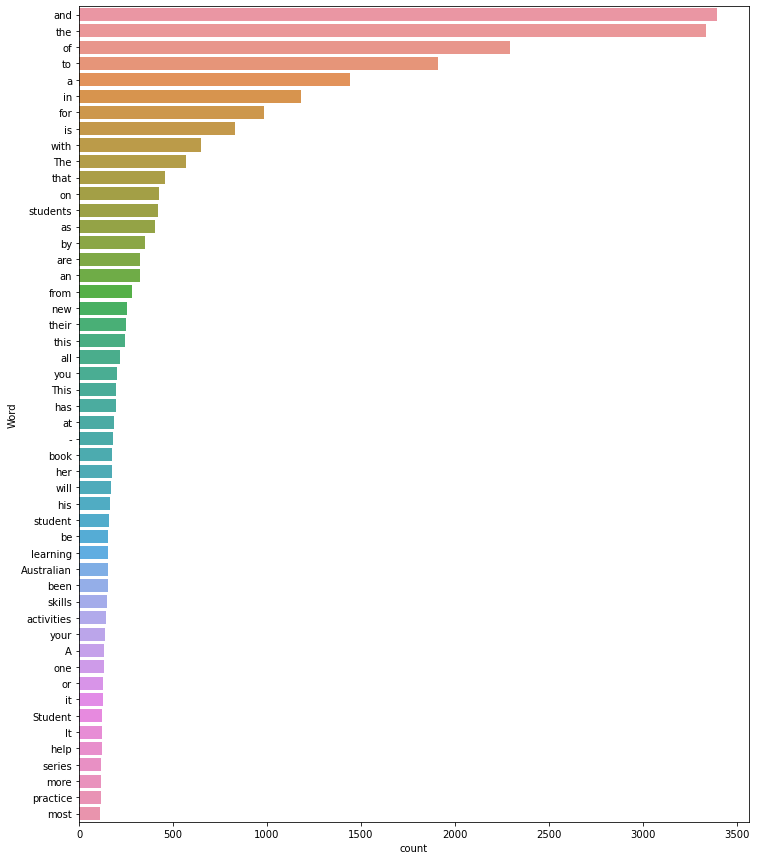

In [71]:

df_google = pd.read_csv('google_api_book_detail.csv', na_values=['NA', '-999'])
# fill NaN values with empty string
df_google.fillna('', inplace=True)

# For our analysis later
df_google['clean_categories'] = df_google['categories'].astype(str).apply(lambda x: clean_text(x)) 
df_google['clean_categories'] = df_google['clean_categories'].astype(str).apply(lambda x: remove_stopwords_and_stem(x))

df_google['clean_title'] = df_google['title'].astype(str).apply(lambda x: clean_text(x)) 
df_google['clean_title'] = df_google['clean_title'].astype(str).apply(lambda x: remove_stopwords_and_stem(x))

# Treat author as one unique name, Trove only returned 1x Author
df_google['clean_author'] = df_google['authors'].str.replace(' ', '')
df_google['clean_author'] = df_google['clean_author'].astype(str).apply(lambda x: clean_text(x)) 
df_google['clean_author'] = df_google['clean_author'].astype(str).apply(lambda x: remove_stopwords_and_stem(x))

df_google['clean_publisher'] = df_google['publisher'].astype(str).apply(lambda x: clean_text(x)) 
df_google['clean_publisher'] = df_google['clean_publisher'].astype(str).apply(lambda x: remove_stopwords_and_stem(x))

df_google['clean_description'] = df_google['description'].astype(str).apply(lambda x: clean_text(x)) 
df_google['clean_description'] = df_google['clean_description'].astype(str).apply(lambda x: remove_stopwords_and_stem(x))

freq_words(df_google['description'], 50) 



In [66]:
df2 = pd.read_csv('google_api_book_detail.csv', na_values=['NA', '-999'])
missing_values_count_google_book = df2.isna().sum()
print(missing_values_count_google_book)

# Missing data: We want to try and locate description data
missing_description_mask = df2['description'].isna()
missing_description_list = df2[missing_description_mask]['title'].tolist()

# We want to try and locate title data:
missing_title_mask = df2['title'].isna()
missing_title_list = df2[missing_title_mask]['isbn'].tolist()


isbn             0
title          115
authors        187
published      118
publisher      577
description    357
categories     384
dtype: int64


# Trove API Request
During our analysis, we discovered that the information we needed was not available in the Google Books API, and we encountered missing data. This is a common challenge in data retrieval, and it is important for data scientists to have backup plans in place to minimize the number of missing observations, such as using other APIs. To enhance our data, we used the Trove API to extract the book title when the description was missing and the ISBN when the title was missing. We performed two Trove API requests, the first one to retrieve missing titles for ISBNs that were not found in Google, and the second one to search for titles using the results from the initial Trove search and the Google search. However, we faced a limitation with Trove, as we were unable to obtain a description when searching using ISBN, as the snippet feature mostly returned empty values for ISBNs. This highlights the importance of data scientists approaching challenges from different angles to ensure a complete and enriched dataset is obtained and trying different search parameters.

In [166]:
# The goal here is to try and find description information as we consider this the most important 
def get_trove_book_info_title(book_name):
    # Define trove connection
    endpoint = 'https://api.trove.nla.gov.au/v2/result'
    
    # Define params
    params = {
        'q': str(book_name), # Can search on ISBN
        'zone': 'book', # Search in the book zone
        'key': "3df38mcts5aquk4l", # API key
        'encoding': 'json', # Default is xml
        'include' : 'tags=comments,workversions'
    }
    
    response = requests.get(endpoint, params=params)
    data = response.json()
    
    try:
        books = data['response']['zone'][0]['records']['work']
        if len(books) > 0:
            book = books[0]
            snippet = book.get('snippet', '')
            if 'version' in book and len(book['version']) > 0:
                version = book['version'][0]
                if 'record' in version and 'publisher' in version['record']:
                    publisher = version['record']['publisher']
                else:
                    publisher = ''
                if 'record' in version and 'issued' in version['record']:
                    published = version['record']['issued']
                else:
                    published = ''
                if 'record' in version and 'subject' in version['record'] and len(version['record']['subject']) > 0:
                    categories = []
                    for subject in version['record']['subject']:
                        if isinstance(subject, dict) and 'value' in subject:
                            categories.append(subject['value'])
                        else:
                            categories.append(subject)
                else:
                    categories = ''
            else:
                publisher = ''
                published = ''
                categories = ''
            author = book.get('contributor', '')
            if author:
                author_name = author[0].split(',')[0].strip()  # get last name 
                if len(author[0].split(',')) > 1:
                    author_first_initial = author[0].split(',')[1].strip().split()[0]  # get first name/initial
                    formatted_author = f"{author_first_initial} {author_name}"  # combine first and last name to match google API
                else:
                    formatted_author = author_name
            else:
                formatted_author = ''
            return {'title': book_name, 'description': snippet, 'publisher': publisher, 'published': published, 'authors': formatted_author, 'categories': categories}
        else:
            return None
    except KeyError:
        return None
    


{'isbn': 9781316606735, 'title': 'New cambridge shakespeare'}

In [69]:
# Extract title from trove, then we will do another search on titles to find description via snippet
def get_trove_book_info_isbn(isbn):
    # Define trove connection
    endpoint = 'https://api.trove.nla.gov.au/v2/result'
    
    # Define params
    params = {
        'q': str(isbn), # Can search on ISBN
        'zone': 'book', # Search in the book zone
        'key': "3df38mcts5aquk4l", # API key
        'encoding': 'json', # Default is xml
        'include' : 'tags=comments,workversions'
    }
    response = requests.get(endpoint, params=params)
    data = response.json()
    if 'work' in data['response']['zone'][0]['records']:
        book_info = data['response']['zone'][0]['records']['work']
        book = book_info[0]
        full_title = book.get('title', '') 
        title = full_title.split(' / ')[0] #
        return{'isbn': isbn, 'title': title}
get_trove_book_info_isbn(9781316606735)



book_info_list = []

start_time = datetime.datetime.now()
for isbn in tqdm.tqdm(missing_title_list, desc=f"Retrieving book information for ISBNs {missing_title_list[0]} to {missing_title_list[-1]}"):
    try:
        book_info = get_trove_book_info_isbn(isbn)
        book_info_list.append(book_info)
    except:
        print(f'ISBN ERROR {isbn}')
    time.sleep(2) # Prevent getting blocked on server
end_time = datetime.datetime.now()
time_taken = end_time - start_time
print(f"Time taken: {time_taken}") 

book_info_list = list(filter(None, book_info_list))
trove_title_data = pd.DataFrame(book_info_list)
titles_list = trove_title_data['title'].tolist()
titles_list


Retrieving book information for ISBNs 9781876424503 to 9780170368667:   0%|                    | 0/115 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [181]:
# Now we have missing titles from google found in trove, we will search for the reminder information using title only

book_info_list = []

start_time = datetime.datetime.now()
for title in tqdm.tqdm(titles_list, desc=f"Retrieving book information for missing books"):
    try:
        # Search for book information using title
        book_info = get_trove_book_info_title(title)
        
        # Find the ISBN associated with the title from df2
        isbn = trove_title_data.loc[trove_title_data['title'] == title, 'isbn'].values[0]
        
        # Add the ISBN to the book information dictionary
        book_info['isbn'] = isbn
        
        # Append the book information to the list
        book_info_list.append(book_info)
    except:
        print(f'Error retrieving book information for {title}')
    
    # Sleep to prevent getting blocked by the server
    time.sleep(2) 

end_time = datetime.datetime.now()
time_taken = end_time - start_time
print(f"Time taken: {time_taken}")

df_trove_description = pd.DataFrame(book_info_list)
df_trove_description

Retrieving book information for missing books: 100%|███████████████████████████████████| 63/63 [03:58<00:00,  3.78s/it]

Time taken: 0:03:58.031027


,title,description,publisher,published,authors,categories,isbn
0,Teaching THRASS whole word picture phonics : t...,[<b>Teaching</b> <b>THRASS</b> <b>whole</b> <b...,"Osborne Park, W.A. : THRASS Australia,",2003,Denyse Ritchie,"[English language -- Pronunciation., Literacy ...",9781876424503
1,Sound waves : words and sounds book,[<b>Sound</b> <b>waves</b> : <b>words</b> <b>a...,,2013,Barbara Murray,[English language -- Orthography and spelling ...,9781741352696
2,Maths Mate 7 Student Pad,<b>Maths</b> <b>Mate</b> <b>7</b> <b>Student</...,"Educational Advantage Pty Ltd,",2003,,,9781876081621
3,Maths Mate 8 Student Pad,<b>Maths</b> <b>Mate</b> <b>8</b> <b>Student</...,"Educational Advantage Pty Ltd ,",2003,,,9781876081638
4,"Music theory for cool cats : beginner book A, ...",<b>Music</b> <b>theory</b> <b>for</b> <b>cool<...,"Donvale : Bushfire,",2000,Deana Dodds,"[Recorders (Musical instruments), Music -- Pro...",9781875191987
...,...,...,...,...,...,...,...
58,CSM AC specialist mathematics year 12 digital ...,<b>CSM</b> <b>AC</b> <b>specialist</b> <b>math...,"Port Melbourne, Vic. : Cambridge University Pr...",2017,Michael Evans,"[E, d, u, c, a, t, i, o, n, a, l, :, , M, a, ...",9781316882368
59,Cambridge senior mathematics for queensland sp...,[<b>Cambridge</b> <b>senior</b> <b>mathematics...,,2018,,"[A, u, s, t, r, a, l, i, a, n]",9781108623995
60,"Power, accountability & rights : WACE politics...","[<b>Power</b>, <b>accountability</b> & <b>righ...",,2021,Stephen King,"[Western Australian Certificate of Education.,...",9780648930105
61,Cambridge VCE health and human development uni...,<b>Cambridge</b> <b>VCE</b> <b>health</b> <b>a...,"Port Melbourne, Vic. : Cambridge University Pr...",2017,Sonia Goodacre,"[E, d, u, c, a, t, i, o, n, a, l, :, , P, e, ...",9781108265225


In [70]:

book_info_list = []


start_time = datetime.datetime.now()
for title in tqdm.tqdm(missing_description_list, desc=f"Retrieving book information for missing books"):
    try:
        # Search for book information using title
        book_info = get_trove_book_info_title(title)
        
        # Find the ISBN associated with the title from df2
        isbn = df2.loc[df2['title'] == title, 'isbn'].values[0]
        
        # Add the ISBN to the book information dictionary
        book_info['isbn'] = isbn
        
        # Append the book information to the list
        book_info_list.append(book_info)
    except:
        print(f'Error retrieving book information for {title}')
    
    # Sleep to prevent getting blocked by the server
    time.sleep(2) 

end_time = datetime.datetime.now()
time_taken = end_time - start_time
print(f"Time taken: {time_taken}")

df_google_missing = pd.DataFrame(book_info_list)
df_google_missing


Retrieving book information for missing books:   0%|                                           | 0/357 [00:00<?, ?it/s]

Error retrieving book information for Victorian Targeting Handwriting


Retrieving book information for missing books:   0%|                                   | 1/357 [00:02<11:52,  2.00s/it]

Error retrieving book information for The Beginner's Bible


Retrieving book information for missing books:   0%|                                   | 1/357 [00:04<23:46,  4.01s/it]


KeyboardInterrupt: 

In [212]:
# Merge our trove data together
#combined_trove_df = pd.concat([df_trove_description, df_google_missing], ignore_index=True)
#combined_trove_df.to_csv('trove_api_data.csv', index=False)

In [209]:
#combined_trove_df

,title,description,publisher,published,authors,categories,isbn
0,Teaching THRASS whole word picture phonics : t...,[<b>Teaching</b> <b>THRASS</b> <b>whole</b> <b...,"Osborne Park, W.A. : THRASS Australia,",2003,Denyse Ritchie,"[English language -- Pronunciation., Literacy ...",9781876424503
1,Sound waves : words and sounds book,[<b>Sound</b> <b>waves</b> : <b>words</b> <b>a...,,2013,Barbara Murray,[English language -- Orthography and spelling ...,9781741352696
2,Maths Mate 7 Student Pad,<b>Maths</b> <b>Mate</b> <b>7</b> <b>Student</...,"Educational Advantage Pty Ltd,",2003,,,9781876081621
3,Maths Mate 8 Student Pad,<b>Maths</b> <b>Mate</b> <b>8</b> <b>Student</...,"Educational Advantage Pty Ltd ,",2003,,,9781876081638
4,"Music theory for cool cats : beginner book A, ...",<b>Music</b> <b>theory</b> <b>for</b> <b>cool<...,"Donvale : Bushfire,",2000,Deana Dodds,"[Recorders (Musical instruments), Music -- Pro...",9781875191987
...,...,...,...,...,...,...,...
288,"Acting Smart, Theatre Studies - Version 8",[<b>Acting</b> <b>Smart</b> : <b>theatre</b> <...,"Melbourne : Acting Smart,",2007,Jane Bird,[Theater -- Study and teaching (Secondary) -- ...,9781108469906
289,Business Management 4th Edition,<b>Business</b> <b>Management</b> <b>4th</b> <...,"Camberwell : IBID Press,",2018,Hoang,,9781921917905
290,IB French B Course Book Pack: Oxford IB Diplom...,[<b>IB</b> <b>French</b> <b>B</b> <b>Course</b...,"UK : Oxford University Press,",2018,Christine Trumper,,9780198422372
291,Jacaranda Geography Alive 9 Australian Curricu...,[<b>Jacaranda</b> <b>geography</b> <b>alive</b...,,2018,Judy Mraz,"[Programmes d'études -- Australie., Géograph...",9780730347132


# Clean trove API data
To ensure uniformity of data format, we utilized NLTK and BeautifulSoup for HTML element cleaning to standardize and clean the columns of both the Google and Trove APIs. We developed custom functions as specified at the start of the script. To prevent potential errors stemming from disparities in metadata quality, we standardized the columns individually before consolidating them into a single document. 

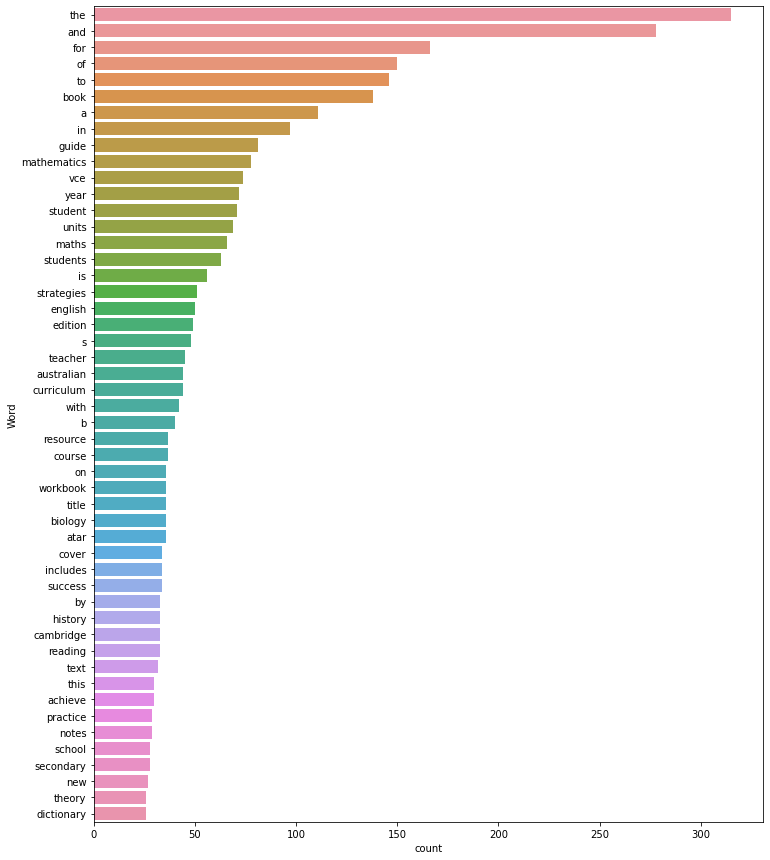

,title,description,publisher,published,authors,categories,isbn,clean_categories,clean_title,clean_author,clean_publisher,clean_description
0,Teaching THRASS whole word picture phonics : t...,['<b>Teaching</b> <b>THRASS</b> <b>whole</b> <...,"Osborne Park, W.A. : THRASS Australia,",2003,Denyse Ritchie,"['English language -- Pronunciation.', 'Litera...",9781876424503,english languag pronunci literaci studi teach ...,teach thrass whole word pictur phonic essenti ...,denysritchi,osborn park w thrass australia,teach thrass whole word pictur phonic essenti ...
1,Sound waves : words and sounds book,['<b>Sound</b> <b>waves</b> : <b>words</b> <b>...,,2013,Barbara Murray,['English language -- Orthography and spelling...,9781741352696,english languag orthographi spell studi teach ...,sound wave word sound book,barbaramurray,,sound wave word sound book whole school phonem...
2,Maths Mate 7 Student Pad,<b>Maths</b> <b>Mate</b> <b>7</b> <b>Student</...,"Educational Advantage Pty Ltd,",2003,,,9781876081621,,math mate student pad,,educ advantag pti ltd,math mate student pad
3,Maths Mate 8 Student Pad,<b>Maths</b> <b>Mate</b> <b>8</b> <b>Student</...,"Educational Advantage Pty Ltd ,",2003,,,9781876081638,,math mate student pad,,educ advantag pti ltd,math mate student pad
4,"Music theory for cool cats : beginner book A, ...",<b>Music</b> <b>theory</b> <b>for</b> <b>cool<...,"Donvale : Bushfire,",2000,Deana Dodds,"['Recorders (Musical instruments)', 'Music -- ...",9781875191987,record music instrument music problem exercis etc,music theori cool cat beginn book record edit,deanadodd,donval bushfir,music theori cool cat beginn book record edit
...,...,...,...,...,...,...,...,...,...,...,...,...
288,"Acting Smart, Theatre Studies - Version 8",['<b>Acting</b> <b>Smart</b> : <b>theatre</b> ...,"Melbourne : Acting Smart,",2007,Jane Bird,['Theater -- Study and teaching (Secondary) --...,9781108469906,theater studi teach secondari australia victor...,act smart theatr studi version,janebird,melbourn act smart,act smart theatr studi act smart theatr studi ...
289,Business Management 4th Edition,<b>Business</b> <b>Management</b> <b>4th</b> <...,"Camberwell : IBID Press,",2018,Hoang,,9781921917905,,busi manag th edit,hoang,camberwel ibid press,busi manag th edit
290,IB French B Course Book Pack: Oxford IB Diplom...,['<b>IB</b> <b>French</b> <b>B</b> <b>Course</...,"UK : Oxford University Press,",2018,Christine Trumper,,9780198422372,,ib french b cours book pack oxford ib diploma ...,christintrumper,uk oxford univers press,ib french b cours book pack oxford ib diploma ...
291,Jacaranda Geography Alive 9 Australian Curricu...,['<b>Jacaranda</b> <b>geography</b> <b>alive</...,,2018,Judy Mraz,"[""Programmes d'études -- Australie."", 'Géogr...",9780730347132,programm de tude australi ge ographi e tude et...,jacaranda geographi aliv australian curriculum...,judimraz,,jacaranda geographi aliv australian curriculum...


In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import requests
import re
from collections import Counter
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize


# Read in Trove API data
df_trove = pd.read_csv('trove_api_data.csv', na_values=['NA', '-999'])

# Fill missing values with empty string
df_trove.fillna('', inplace=True)



df_trove['clean_categories'] = df_trove['categories'].astype(str).apply(lambda x: clean_text(x)) 
df_trove['clean_categories'] = df_trove['clean_categories'].astype(str).apply(lambda x: remove_stopwords_and_stem(x))

df_trove['clean_title'] = df_trove['title'].astype(str).apply(lambda x: clean_text(x)) 
df_trove['clean_title'] = df_trove['clean_title'].astype(str).apply(lambda x: remove_stopwords_and_stem(x))

# Treat author as one unique name, Trove only returned 1x Author
df_trove['clean_author'] = df_trove['authors'].astype(str).apply(lambda x: clean_text(x)) 
df_trove['clean_author'] = df_trove['clean_author'].astype(str).apply(lambda x: remove_stopwords_and_stem(x))
df_trove['clean_author'] = df_trove['clean_author'].str.replace(' ', '')

df_trove['clean_publisher'] = df_trove['publisher'].astype(str).apply(lambda x: clean_text(x)) 
df_trove['clean_publisher'] = df_trove['clean_publisher'].astype(str).apply(lambda x: remove_stopwords_and_stem(x))

df_trove['clean_description'] = df_trove['description'].apply(clean_html) # HTML enconced, need to clean
freq_words(df_trove['clean_description'], 50) 
df_trove['clean_description'] = df_trove['clean_description'].astype(str).apply(lambda x: clean_text(x)) 
df_trove['clean_description'] = df_trove['clean_description'].astype(str).apply(lambda x: remove_stopwords_and_stem(x))



df_trove

# Augment Google API with Trove
At this stage both our Google and Trove data was in a similar structure, and we combined the two sources together as summarised by the rules below via the pd.merge() function. 


Merge based on thse rules:
- Clean title: If Google missing merge Trove
- Clean Author: If google missing merge Trove	
- Clean Publisher: If Google missing merge Trove	
- Clean Categories: If Trove missing merge Google	
- Clean description: If Google missing merge Trove	




In [74]:
merged_df = pd.merge(df_google, df_trove, on='isbn', how = 'outer')
merged_df
print(merged_df.columns)


# Merge google, trove 
merged_df = pd.merge(df_google, df_trove, on='isbn', how = 'outer')

# fill in missing values with data from the other data frame
merged_df['clean_title_x'].fillna(merged_df['clean_title_y'], inplace=True)
merged_df['clean_author_x'].fillna(merged_df['clean_author_y'], inplace=True)
merged_df['published_x'].fillna(merged_df['published_y'], inplace=True)
merged_df['clean_publisher_x'].fillna(merged_df['clean_publisher_y'], inplace=True) 
merged_df['clean_categories_y'].fillna(merged_df['clean_categories_x'], inplace=True) # Will retain categories y as dominent as it has more info then google, this will be useful if description is missing 
merged_df['clean_description_x'].fillna(merged_df['clean_description_y'], inplace=True)

#merged_df.to_csv('merged_df.csv', index=False)
# drop the redundant columns from the merged data frame
# drop the redundant columns from the merged data frame
merged_df.drop(['clean_title_y', 'clean_author_y', 'published_y', 'clean_publisher_y', 'clean_categories_x' , 'clean_description_y'], axis=1, inplace=True)





# Rename the columns to remove the suffix '_y' or '_x'
merged_df.rename(columns={
    'clean_title_x': 'title',
    'clean_author_x': 'authors',
    'clean_published_x': 'published',
    'clean_publisher_x': 'publisher',
    'clean_categories_y': 'categories',
    'clean_description_x': 'clean_description'
}, inplace=True)


# drop the rows where 'title' is missing
merged_df = merged_df[['isbn', 'title', 'clean_description', 'authors', 'publisher', 'categories']]
merged_df['cat_des'] = merged_df['clean_description'].astype(str) + ' ' + merged_df['categories'].astype(str) 

merged_df.dropna(subset=['title'], inplace=True)

merged_df.replace('', np.nan, inplace=True)

# Drop rows with missing titles
merged_df.dropna(subset=['title'], inplace=True) # We consider this crucial for our ML model

# Count the number of unique ISBNs
unique_isbns = merged_df['isbn'].nunique()

# Print the results
print('Number of rows after dropping missing titles:', len(merged_df))
print('Number of unique ISBNs:', unique_isbns)

na_count = merged_df.isna().sum()
print(na_count)
len(merged_df)
merged_df.to_csv('clean_merged_api_data.csv', index=False)

Index(['isbn', 'title_x', 'authors_x', 'published_x', 'publisher_x',
       'description_x', 'categories_x', 'clean_categories_x', 'clean_title_x',
       'clean_author_x', 'clean_publisher_x', 'clean_description_x', 'title_y',
       'description_y', 'publisher_y', 'published_y', 'authors_y',
       'categories_y', 'clean_categories_y', 'clean_title_y', 'clean_author_y',
       'clean_publisher_y', 'clean_description_y'],
      dtype='object')
Number of rows after dropping missing titles: 990
Number of unique ISBNs: 948
isbn                   0
title                  0
clean_description    282
authors               81
publisher            498
categories           235
cat_des                0
dtype: int64


# Deciding on features
We introduced a new feature called "clean text," which was a combination of the title, categories, and description. Through a trial-and-error process, we tested various combinations of text features and selected the one that resulted in the highest test F1 score for our out-of-box model (default parameters). 

In [12]:
merged_df = pd.read_csv('clean_merged_api_data.csv')

In [13]:
# Create a text column:
#merged_df['text'] = merged_df['title'].astype(str) + ' ' + merged_df['authors'].astype(str) + ' ' +  merged_df['publisher'].astype(str) + ' ' + merged_df['description'].astype(str)+ ' ' + merged_df['categories'].astype(str)
merged_df['clean_text1'] = merged_df['title'].astype(str) 
merged_df['clean_text2'] = merged_df['title'].astype(str) + ' ' + merged_df['clean_description'].astype(str)
merged_df['clean_text3'] = merged_df['title'].astype(str) + ' ' + merged_df['authors'].astype(str)
merged_df['clean_text4'] = merged_df['title'].astype(str) + ' ' + merged_df['categories'].astype(str)
merged_df['clean_text5'] = merged_df['title'].astype(str) + ' ' + merged_df['publisher'].astype(str)
merged_df['clean_text6'] = merged_df['title'].astype(str) + ' ' + merged_df['categories'].astype(str) + ' ' + merged_df['clean_description'].astype(str)
merged_df['clean_text7'] = merged_df['title'].astype(str) + ' ' + merged_df['categories'].astype(str) + ' ' + merged_df['clean_description'].astype(str) + ' ' + merged_df['authors'].astype(str)
merged_df['clean_text8'] = merged_df['title'].astype(str) + ' ' + merged_df['categories'].astype(str) + ' ' + merged_df['clean_description'].astype(str) + ' ' + merged_df['authors'].astype(str)+ ' ' + merged_df['publisher'].astype(str)


# Through tiral and error clean_text_6 was the best combination based on validation F1




# EDA On Text Corpus
At this stage we conducted some EDA on our clean text, we explored most common author, most common category and most common publisher and observed the following characteristics (fig 7):
-	Most common Authors: Chris Linthorn & William Shakespear
-	Most common Category: Languages and Studies
-	Most common publisher: Cambridge University Press


Most Common Author


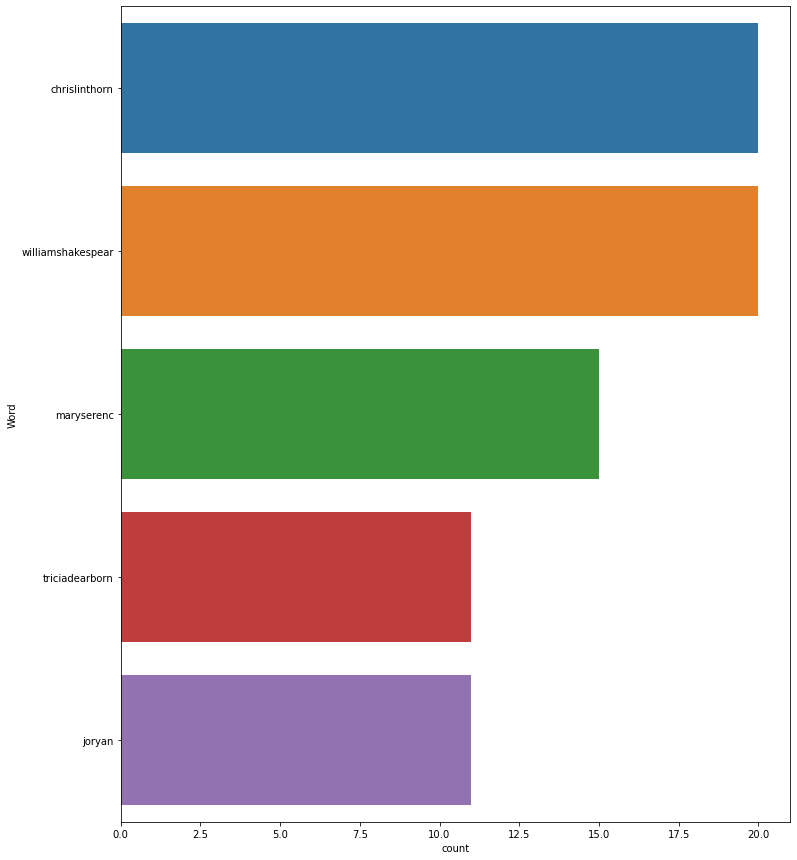

In [14]:
# Fill na so we can do EDA
merged_df['title'] = merged_df['title'].fillna('')
merged_df['clean_description'] = merged_df['clean_description'].fillna('')
merged_df['authors'] = merged_df['authors'].fillna('')
merged_df['publisher'] = merged_df['publisher'].fillna('')
merged_df['categories'] = merged_df['categories'].fillna('')
print("Most Common Author")
freq_words(merged_df['authors'], 5) 


Most Common Categories


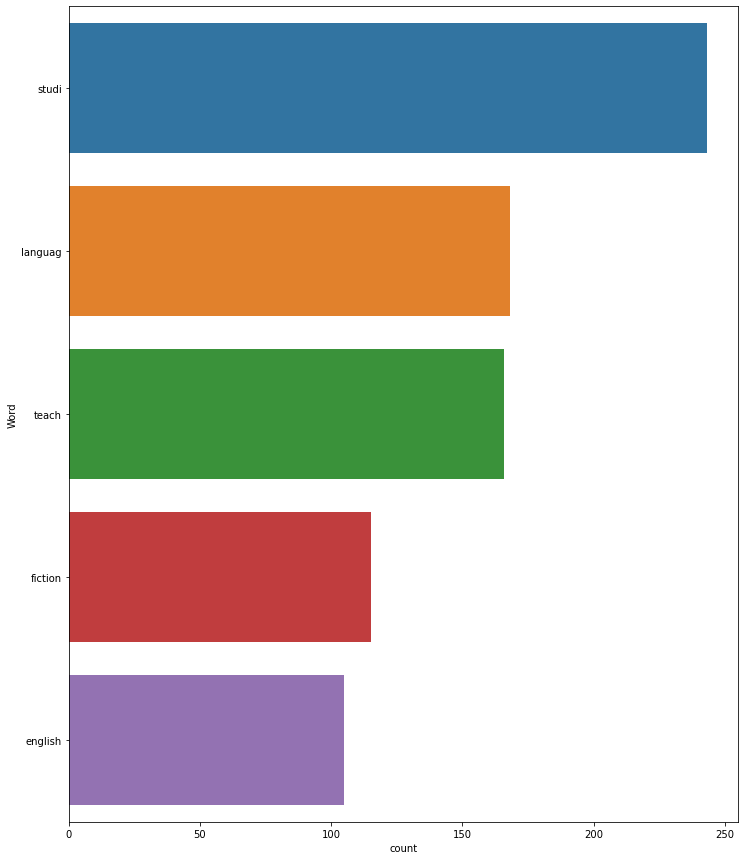

In [15]:
print("Most Common Categories")
freq_words(merged_df['categories'], 5) 

Most Common Publisher


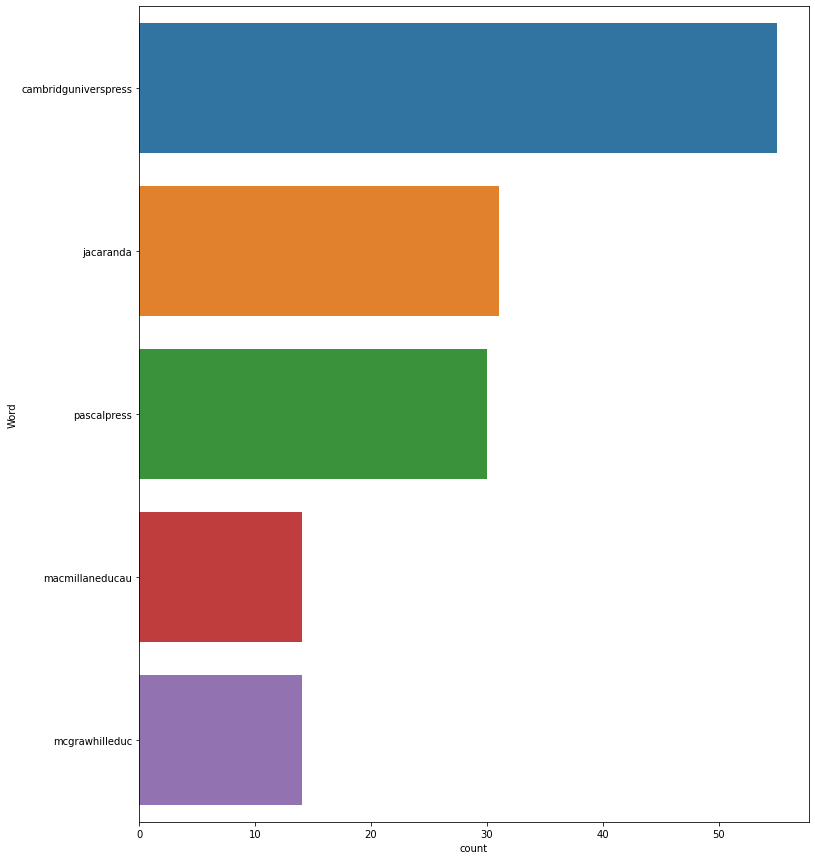

In [16]:
merged_df['merged_publisher'] = merged_df['publisher'].str.replace(' ', '')
print("Most Common Publisher")
freq_words(merged_df['merged_publisher'], 5) 

In [17]:

# Reviewing graph we need to remove some words which have not been removed
stop_words.add('nan')
stop_words.add('e')


# Best model
merged_df['clean_text'] = merged_df['clean_text6'].apply(lambda x: remove_stopwords_and_stem(x))


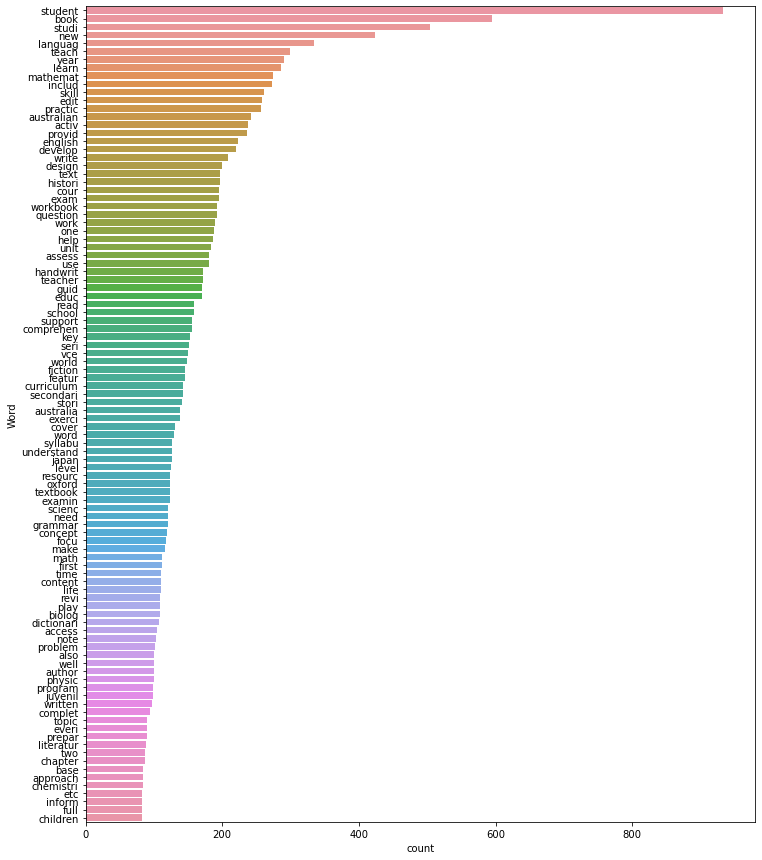

In [18]:
freq_words(merged_df['clean_text'], 100)


# Developing model
In this stage of our analysis, we merged our user ground truth data with our corpus of text using the pd.merge() function.


In [19]:
df = pd.read_csv('jcu_sample_data_proccessed.csv', converters={'User_type': eval})
merged_df_analysis = pd.merge(merged_df, df, left_on='isbn', right_on = 'ISBN', how = 'left')

In [20]:
merged_df_analysis = merged_df_analysis[['isbn', 'clean_text', 'User_type']]
merged_df_analysis = merged_df_analysis.dropna(subset=['User_type']) # drop rows with missing values - 5 we removed earlier
merged_df_analysis


,isbn,clean_text,User_type
0,9781741250879,victorian target handwrit penmanship studi tea...,[ENGLISH_0]
1,9780648237327,kluwel home read yellow level suitabl lower pr...,"[ENGLISH_2, ENGLISH_0, ENGLISH_1, MATHEMATICS_..."
2,9781742990682,wilfrid gordon mcdonald partridg boy wilfrid g...,[ENGLISH_0]
3,9781741351750,imath mathemat imath investig base numeraci pr...,[ENGLISH_0]
4,9781742152196,nelson math australian curriculum mathemat nel...,[ENGLISH_0]
...,...,...,...
985,9780730365464,jacaranda math quest australian curriculum lea...,[MATHEMATICS_12]
986,9781107628199,physic ib diploma coursebook free onlin materi...,[SCIENCE_11]
987,9780415684811,global polit polit scienc nd edit global polit...,[HUMANITIES_11]
988,9781420229431,queensland senior physic educ physic educ trai...,[PDHPE_11]


# KNN Model Development

In [22]:
import collections

# Get a list of all user types
user_types = [user_type for row in merged_df_analysis['User_type'] for user_type in row]

# Count the occurrences of each user type
user_type_counts = Counter(user_types)

# Remove user types that occur less than 10 times
user_type_counts = {k: v for k, v in user_type_counts.items() if v >= 5}

# Filter the rows of the dataframe to only include user types that occur at least 10 times
filtered_df = merged_df_analysis[
    merged_df_analysis['User_type'].apply(
        lambda x: any(user_type in user_type_counts for user_type in x)
    )
]
print(len(filtered_df))

# Sort the user type counts by value in ascending order
sorted_counts = sorted(user_type_counts.items(), key=lambda x: x[1])

# Print the first 10 items (i.e., the user types with the smallest counts)
for user_type, count in sorted_counts[:20]:
    print(f"{user_type}: {count}")

# 5 Good Accuracy: Through a grid search we tuned number of users
filtered_df

900
MATHEMATICS_1: 5
SCIENCE_7: 5
MATHEMATICS_8: 5
SCIENCE_8: 5
PSYCHOLOGY_11: 5
PDHPE_11: 5
BUSINESS STUDIES_11: 5
MATHEMATICS_7: 6
MATHEMATICS_10: 6
HUMANITIES_12: 6
FOOD TECHNOLOGY_12: 6
RELIGIOUS EDUCATION_12: 7
SCIENCE_9: 7
HISTORY_11: 8
BUSINESS STUDIES_12: 8
ECONOMICS_12: 8
SCIENCE_10: 9
HISTORY_10: 10
ACCOUNTING_12: 10
DESIGN AND TECHNOLOGY_12: 11


,isbn,clean_text,User_type
0,9781741250879,victorian target handwrit penmanship studi tea...,[ENGLISH_0]
1,9780648237327,kluwel home read yellow level suitabl lower pr...,"[ENGLISH_2, ENGLISH_0, ENGLISH_1, MATHEMATICS_..."
2,9781742990682,wilfrid gordon mcdonald partridg boy wilfrid g...,[ENGLISH_0]
3,9781741351750,imath mathemat imath investig base numeraci pr...,[ENGLISH_0]
4,9781742152196,nelson math australian curriculum mathemat nel...,[ENGLISH_0]
...,...,...,...
984,9781107587434,cambridg vce health human develop unit pack he...,[MATHEMATICS_12]
985,9780730365464,jacaranda math quest australian curriculum lea...,[MATHEMATICS_12]
986,9781107628199,physic ib diploma coursebook free onlin materi...,[SCIENCE_11]
988,9781420229431,queensland senior physic educ physic educ trai...,[PDHPE_11]


In [23]:
# Split the data into train and test sets
random.seed(123) 

# Filter out UndefinedMetricWarning warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

data = filtered_df.copy()
train_data, test_data = train_test_split(data, test_size=0.2, random_state=10)


# Vectorize the clean_text using TF-IDF
vectorizer = TfidfVectorizer(max_features = 10000)
#vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data['clean_text'])
X_test = vectorizer.transform(test_data['clean_text'])

# Encode the User_type using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(train_data['User_type'])
y_test = mlb.transform(test_data['User_type'])


# Get the vocabulary and number of words
vocabulary = vectorizer.get_feature_names()
num_words = len(vocabulary)

# Calculate the number of tokens in train and test sets
num_train_tokens = X_train.sum()
num_test_tokens = X_test.sum()

# Calculate the mean number of tokens per document
mean_train_tokens = num_train_tokens / len(train_data)
mean_test_tokens = num_test_tokens / len(test_data)

# Print summary statistics
print("Number of documents in train set:", len(train_data))
print("Number of documents in test set:", len(test_data))
print("Number of words in vocabulary:", num_words)
print("Number of tokens in train set:", num_train_tokens)
print("Number of tokens in test set:", num_test_tokens)
print("Mean number of tokens per document in train set:", mean_train_tokens)
print("Mean number of tokens per document in test set:", mean_test_tokens)


Number of documents in train set: 720
Number of documents in test set: 180
Number of words in vocabulary: 5418
Number of tokens in train set: 3500.4593362056394
Number of tokens in test set: 852.9596585648057
Mean number of tokens per document in train set: 4.861749078063388
Mean number of tokens per document in test set: 4.738664769804476


C:\Users\jayde\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:860: UserWarning: unknown class(es) ['AGRICULTURE_12', 'COMPUTER SCIENCE_10', 'COMPUTER SCIENCE_12', 'LANGUAGES_2', 'LANGUAGES_3', 'SCIENCE_6'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

# Split the data into train and test sets
random.seed(123) 
train_data, test_data = train_test_split(filtered_df, test_size=0.2, random_state=10)

# Create a TfidfVectorizer instance with desired parameters
vectorizer = TfidfVectorizer(stop_words='english')

# Fit the vectorizer on the training data
vectorizer.fit(train_data['clean_text'].values)

# Get the vocabulary and number of words
vocabulary = vectorizer.get_feature_names()
num_words = len(vocabulary)

# Define the max_features parameter based on the number of words
max_features = min(num_words, 1000)

# Set the max_features parameter and transform the text data
vectorizer.max_features = max_features
X_train = vectorizer.transform(train_data['clean_text'].values)
X_test = vectorizer.transform(test_data['clean_text'].values)

# Encode the User_type using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(train_data['User_type'])
y_test = mlb.transform(test_data['User_type'])

# Calculate the number of tokens in train and test sets
num_train_tokens = X_train.sum()
num_test_tokens = X_test.sum()

# Calculate the mean number of tokens per document
mean_train_tokens = num_train_tokens / len(train_data)
mean_test_tokens = num_test_tokens / len(test_data)

# Print summary statistics
print("Number of documents in train set:", len(train_data))
print("Number of documents in test set:", len(test_data))
print("Number of words in vocabulary:", num_words)
print("Number of tokens in train set:", num_train_tokens)
print("Number of tokens in test set:", num_test_tokens)
print("Mean number of tokens per document in train set:", mean_train_tokens)
print("Mean number of tokens per document in test set:", mean_test_tokens)


Number of documents in train set: 720
Number of documents in test set: 180
Number of words in vocabulary: 5325
Number of tokens in train set: 3414.21583391293
Number of tokens in test set: 827.1209176367889
Mean number of tokens per document in train set: 4.7419664359901805
Mean number of tokens per document in test set: 4.595116209093272


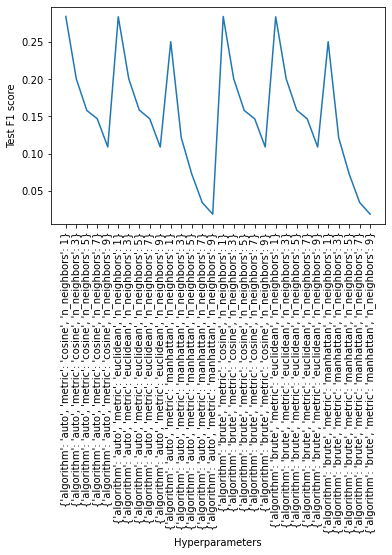

Best hyperparameters: {'algorithm': 'auto', 'metric': 'cosine', 'n_neighbors': 1}
Best TEST F1 score: 0.2839678724352491


In [25]:
# TUNE OUR MODEL PARAMATER
# Filter out UndefinedMetricWarning warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
random.seed(123)

# Train our model
# Define the hyperparameters to tune
import random
random.seed(123)

param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9],
    'algorithm': ['auto', 'brute'],
    'metric': ['cosine', 'euclidean', 'manhattan']
}

# Perform the grid search
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=5, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

# Get the results and the corresponding F1 scores
results = grid_search.cv_results_
f1_scores = results['mean_test_score']

# Plot the F1 scores for each combination of hyperparameters
fig, ax = plt.subplots()
ax.plot(range(len(f1_scores)), f1_scores)
ax.set_xticks(range(len(f1_scores)))
ax.set_xticklabels([str(params) for params in results['params']])
ax.set_xticklabels([str(params) for params in results['params']], rotation=90)
ax.set_xlabel('Hyperparameters')
ax.set_ylabel('Test F1 score')
plt.show()

# Get the best F1 score and its corresponding hyperparameters
best_f1_score = grid_search.best_score_
best_params = grid_search.best_params_

# Print the best hyperparameters and their F1 score
print(f"Best hyperparameters: {best_params}")
print(f"Best TEST F1 score: {best_f1_score}")


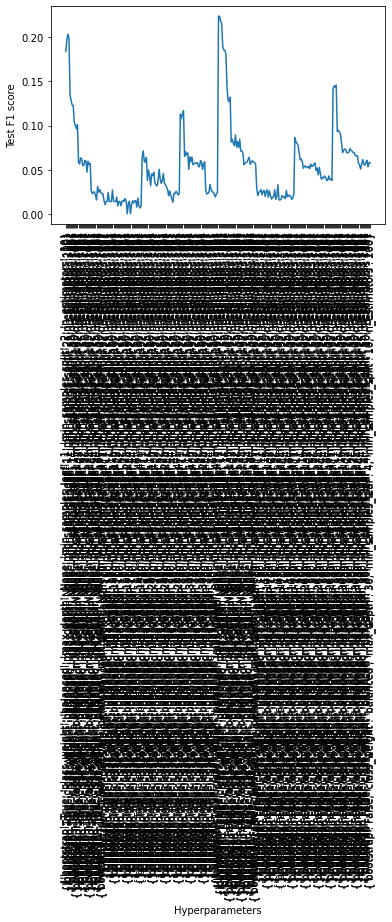

Best hyperparameters: {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Best TEST F1 score: 0.22393093109564988


In [29]:
# WHAT ABOUT RANDOM FOREST? Could it be better at classifying?
# Train our model
# Define the hyperparameters to tune
random.seed(123)


param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': ['balanced']
}

# Perform the grid search
grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

# Get the results and the corresponding F1 scores
results = grid_search.cv_results_
f1_scores = results['mean_test_score']

# Plot the F1 scores for each combination of hyperparameters
fig, ax = plt.subplots()
ax.plot(range(len(f1_scores)), f1_scores)
ax.set_xticks(range(len(f1_scores)))
ax.set_xticklabels([str(params) for params in results['params']])
ax.set_xticklabels([str(params) for params in results['params']], rotation=90)
ax.set_xlabel('Hyperparameters')
ax.set_ylabel('Test F1 score')
plt.show()

# Get the best F1 score and its corresponding hyperparameters
best_f1_score = grid_search.best_score_
best_params = grid_search.best_params_

# Print the best hyperparameters and their F1 score
print(f"Best hyperparameters: {best_params}")
print(f"Best TEST F1 score: {best_f1_score}")

We elected to procced with KK based on above results, even thouhg we have unabalnced data - though we will address this with removing more data points later*

In [48]:
# BUILD OUR MODEL AND EVALUATE
# Filter out UndefinedMetricWarning warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=UserWarning)
random.seed(123)


# Train a K-Nearest Neighbors model
model = KNeighborsClassifier(metric='cosine', algorithm='auto', n_neighbors = 1)
#model = KNeighborsClassifier(metric='cosine', algorithm='auto')
model.fit(X_train, y_train)


# Predict on the test set
y_pred = model.predict(X_test)

# Predict on the train set
y_pred_train = model.predict(X_train)

# Calculate the metrics
f1_test = f1_score(y_test, y_pred, average='micro')
f1_train = f1_score(y_train, y_pred_train, average='micro')
precision_test = precision_score(y_test, y_pred, average='micro')
precision_train = precision_score(y_train, y_pred_train, average='micro')
recall_test = recall_score(y_test, y_pred, average='micro')
recall_train = recall_score(y_train, y_pred_train, average='micro')
accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train = accuracy_score(y_train, y_pred_train)

# Print the performance metrics
print("Performance metrics on classification of text books")
print(f"Test F1 score: {f1_test:.4f} - Train F1 score: {f1_train:.4f}")
print(f"Test Precision: {precision_test:.4f} - Train Precision: {precision_train:.4f}")
print(f"Test Recall: {recall_test:.4f} - Train Recall: {recall_train}")
print(f"Test Accuracy: {accuracy_test:.4f} - Train Accuracy: {accuracy_train:.4f}")
print()



# Update the recommendation function to return the top n recommendations and their similarity scores (KNN)
def recommend_books(model, vectorized_text, n=2):
    distances, indices = model.kneighbors(vectorized_text, n_neighbors=n)
    similarity_scores = 1 - distances
    return indices, similarity_scores

# Make recommendations for the test set
n_recommendations = 2
test_indices, similarity_scores = recommend_books(model, X_test, n_recommendations)



# Section 2: Calculate F1 score for each test book and store the recommended books in a DataFrame
# create empty lists for storing the data
test_isbns = []
test_users = []
recommended_isbns = []
recommended_users = []
f1_scores = []
similarity_scores_list = []

# Loop through each row of the test set and append recommended books to the list
for i in range(len(test_data)):
    test_isbn = test_data.iloc[i]['isbn']
    test_user = test_data.iloc[i]['User_type']
    recommended_isbns_row = []
    recommended_users_row = []
    similarity_scores_row = []
    
    for idx, sim_score in zip(test_indices[i], similarity_scores[i]):
        rec_isbn = train_data.iloc[idx]['isbn']
        rec_user = train_data.iloc[idx]['User_type']
        #rec_user = ["ENGLISH_12"] # This line makes it a Naive Model, we assign everyone an ENGLISH_12 BOOK
        recommended_isbns_row.append(rec_isbn)
        recommended_users_row.append(rec_user)
        similarity_scores_row.append(sim_score)
        
    # Binarize the test_user and recommended_users_row
    binarized_test_user = mlb.transform([test_user])[0]
    binarized_recommended_users = mlb.transform(recommended_users_row)
    
    # Calculate the F1 score for this row
    f1 = f1_score([binarized_test_user]*len(binarized_recommended_users), binarized_recommended_users, average='weighted')
    
    # Append the data to the corresponding lists
    test_isbns.append(test_isbn)
    test_users.append(test_user)
    recommended_isbns.append(recommended_isbns_row)
    recommended_users.append(recommended_users_row)
    f1_scores.append(f1)
    similarity_scores_list.append(similarity_scores_row)

# Create a dictionary to represent the recommended books for each test book
recommended_books_dict = {
    'Test_ISBN': test_isbns,
    'Test_User': test_users,
    'Recommended_ISBNs': recommended_isbns,
    'Recommended_Users': recommended_users,
    'Similarity_Scores': similarity_scores_list,
    'F1_Score': f1_scores
}

# Convert the dictionary to a pandas dataframe
recommended_books_df = pd.DataFrame(recommended_books_dict)

# Get the mean value of the 'f1_score' column
mean_f1_score = recommended_books_df['F1_Score'].mean()

# Print the dataframe
print("Performance metric on recomnedation system using test data only")
print('Mean F1 Score of Books:', mean_f1_score)
recommended_books_df

Performance metrics on classification of text books
Test F1 score: 0.3949 - Train F1 score: 0.8847
Test Precision: 0.3859 - Train Precision: 0.8763
Test Recall: 0.4043 - Train Recall: 0.8931623931623932
Test Accuracy: 0.2778 - Train Accuracy: 0.8819

Performance metric on recomnedation system using test data only
Mean F1 Score of Books: 0.3871296296296295


,Test_ISBN,Test_User,Recommended_ISBNs,Recommended_Users,Similarity_Scores,F1_Score
0,9780947225698,[DESIGN AND TECHNOLOGY_12],"[9780947225704, 9780947225667]","[[DESIGN AND TECHNOLOGY_12], [DESIGN AND TECHN...","[0.3470323168185492, 0.3470323168185492]",1.000000
1,9780316382007,"[ENGLISH_5, ENGLISH_4]","[9780553294385, 9780571056866]","[[ENGLISH_12], [ENGLISH_8, ENGLISH_11, ENGLISH...","[0.36038968076248845, 0.1952351696183009]",0.000000
2,9780571336173,[ENGLISH_12],"[9780140422108, 9781740818377]","[[ENGLISH_12], [ENGLISH_11, ENGLISH_12]]","[0.2703387591360915, 0.19368248829545653]",1.000000
3,9780725334659,[ENGLISH_6],"[9781740202954, 9781740202992]","[[ENGLISH_0], [ENGLISH_2]]","[1.0, 1.0]",0.000000
4,9780141359410,"[ENGLISH_8, ENGLISH_7]","[9780702235467, 9780099462217]","[[ENGLISH_5], [ENGLISH_12]]","[0.14024223984426398, 0.13828405674889854]",0.000000
...,...,...,...,...,...,...
175,9780190323226,[ENGLISH_6],"[9780190323172, 9780190323219]","[[ENGLISH_3, ENGLISH_1], [ENGLISH_5, MATHEMATI...","[1.0, 1.0]",0.000000
176,9780733970665,[LANGUAGES_11],"[9780733970672, 9780733969027]","[[LANGUAGES_11], [LANGUAGES_12]]","[1.0, 0.6976481859626077]",0.666667
177,9780224025720,"[ENGLISH_3, ENGLISH_4]","[9780142401088, 9780380807345]","[[ENGLISH_3, ENGLISH_4], [ENGLISH_7]]","[0.1431992535545552, 0.1290509209858326]",0.666667
178,9780980874921,"[COMPUTER SCIENCE_12, SCIENCE_12]","[9780170196826, 9781108413473]","[[LANGUAGES_9], [HISTORY_12]]","[0.34315459263548487, 0.3397013761691934]",0.000000


# NAIVE MODEL
How well is out model? Lets assume all users get recomnded the same text book, or the same USERY_TYPE book. In our example the most common user type is a year 12 English Book. We simply assume the recomneder model simply assings everyone a Year 12 Enlgish book

In [49]:
# NAIVE MODEL
# Section 2: Calculate F1 score for each test book and store the recommended books in a DataFrame
# create empty lists for storing the data
test_isbns = []
test_users = []
recommended_isbns = []
recommended_users = []
f1_scores = []
similarity_scores_list = []

# Loop through each row of the test set and append recommended books to the list
for i in range(len(test_data)):
    test_isbn = test_data.iloc[i]['isbn']
    test_user = test_data.iloc[i]['User_type']
    recommended_isbns_row = []
    recommended_users_row = []
    similarity_scores_row = []
    
    for idx, sim_score in zip(test_indices[i], similarity_scores[i]):
        rec_user = ["ENGLISH_12"] # This line makes it a Naive Model, we assign everyone an ENGLISH_12 BOOK
        recommended_isbns_row.append(rec_isbn)
        recommended_users_row.append(rec_user)
        
    # Binarize the test_user and recommended_users_row
    binarized_test_user = mlb.transform([test_user])[0]
    binarized_recommended_users = mlb.transform(recommended_users_row)
    
    # Calculate the F1 score for this row
    f1 = f1_score([binarized_test_user]*len(binarized_recommended_users), binarized_recommended_users, average='weighted')
    
    # Append the data to the corresponding lists
    test_isbns.append(test_isbn)
    test_users.append(test_user)
    recommended_isbns.append(recommended_isbns_row)
    recommended_users.append(recommended_users_row)
    f1_scores.append(f1)
    similarity_scores_list.append(similarity_scores_row)

# Create a dictionary to represent the recommended books for each test book
recommended_books_dict = {
    'Test_ISBN': test_isbns,
    'Test_User': test_users,
    'Recommended_ISBNs': '9780571336173, 9780099462217',
    'Recommended_Users': recommended_users,
    'F1_Score': f1_scores
}

# Convert the dictionary to a pandas dataframe
recommended_books_df = pd.DataFrame(recommended_books_dict)

# Get the mean value of the 'f1_score' column
mean_f1_score = recommended_books_df['F1_Score'].mean()

# Print the dataframe
print('Mean F1 Score of NAIVE Books:', mean_f1_score)
recommended_books_df

Mean F1 Score of NAIVE Books: 0.09879629629629628


,Test_ISBN,Test_User,Recommended_ISBNs,Recommended_Users,F1_Score
0,9780947225698,[DESIGN AND TECHNOLOGY_12],"9780571336173, 9780099462217","[[ENGLISH_12], [ENGLISH_12]]",0.0
1,9780316382007,"[ENGLISH_5, ENGLISH_4]","9780571336173, 9780099462217","[[ENGLISH_12], [ENGLISH_12]]",0.0
2,9780571336173,[ENGLISH_12],"9780571336173, 9780099462217","[[ENGLISH_12], [ENGLISH_12]]",1.0
3,9780725334659,[ENGLISH_6],"9780571336173, 9780099462217","[[ENGLISH_12], [ENGLISH_12]]",0.0
4,9780141359410,"[ENGLISH_8, ENGLISH_7]","9780571336173, 9780099462217","[[ENGLISH_12], [ENGLISH_12]]",0.0
...,...,...,...,...,...
175,9780190323226,[ENGLISH_6],"9780571336173, 9780099462217","[[ENGLISH_12], [ENGLISH_12]]",0.0
176,9780733970665,[LANGUAGES_11],"9780571336173, 9780099462217","[[ENGLISH_12], [ENGLISH_12]]",0.0
177,9780224025720,"[ENGLISH_3, ENGLISH_4]","9780571336173, 9780099462217","[[ENGLISH_12], [ENGLISH_12]]",0.0
178,9780980874921,"[COMPUTER SCIENCE_12, SCIENCE_12]","9780571336173, 9780099462217","[[ENGLISH_12], [ENGLISH_12]]",0.0


# Can we improve our model?
- Simplify model and base user on subject level only
- Limit scope of user base, such as 15 users min required - how does this impact the model

We found that if we remove users with less then 15 observations in the data set that we improve both our model and naive model. Though, this limits the scope of analysis. This can be done just by toggling the start of the model and changing the value for filteigng